In [630]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold


import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [543]:
train = pd.read_csv('~/Documents/AmesHousingML/clean_Data.csv') 

In [544]:
train

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsmt,BsmtQual_Po,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NoBsmt,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondit

## Finding & Dealing with Outliers

In [545]:
train.shape

(2576, 266)

In [546]:
Q1 = train['SalePrice'].quantile(.25)
Q3 = train['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + 5 * IQR

In [547]:
before_outlier_total = train.count()[1]
train.drop(train[train['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train.count()[1]

In [548]:
train.shape

(2571, 266)

In [549]:
before_outlier_total - post_outlier_total

5

TotalHouseSF is very correlated and it will remove some of our features that are seeing some potential multicollinearity. We can still do VIF to confirm.

In [550]:
train_numerics = train.select_dtypes(include=[np.number])

In [649]:
#start a list to keep track of what we want to keep out of our top 10
columns_to_exclude = ['EnclosedPorch', 'Alley_NoAlley', 'LotShape_IR2',
                        'LotConfig_CulDSac', 'Neighborhood_BrDale', 'Neighborhood_MeadowV',
                        'Neighborhood_Sawyer', 'Neighborhood_Timber', 'Neighborhood_Veenker',
                        'Condition1_Feedr', 'Exterior2nd_MetalSd', 'ExterQual_Fa', 
                        'ExterCond_TA', 'Foundation_CBlock', 'BsmtFinType1_BLQ', 
                        'CentralAir_Y', 'Electrical_FuseF', 'GarageType_BuiltIn',
                        'GarageCond_TA', 'BsmtUnfSF', 'BsmtCond_Fa', 'GarageQual_Fa',
                      'BldgType_2fmCon', 'BldgType_Twnhs',# just added bsmt, lowered VIF but lowered R2
                      'MSZoning_FV', 'Neighborhood_Somerst', 'HeatingQC_Gd',
                      'MSZoning_C (all)', 'Condition1_PosN', 'ExterCond_Fa', 'BsmtCond_TA',
                        'HeatingQC_Fa', 'SaleType_WD ', 'MSZoning_RH', 'KitchenAbvGr', 'LotConfig_Inside', 'LandSlope_Mod',
'Exterior1st_CemntBd', 'Exterior2nd_HdBoard',
                      'Fence_NoFence', 'FireplaceQu_TA', 'KitchenQual_Fa', 'BsmtFinType2_NoBsmt',
                      'BsmtQual_TA', 'BsmtExposure_NoBsmt', 'BsmtQual_Fa', 'GarageCond_Fa', 'Fence_MnPrv',
                      'Exterior1st_MetalSd', 'Neighborhood_IDOTRR', 'LotShape_Reg', 'BsmtFinSF1',
                      'BsmtQual_NoBsmt', 'BsmtCond_NoBsmt', 'BsmtFinType1_NoBsmt', 
                      'PID', 'MSZoning_RL', 'NonHouseSF', 'RoofStyle_Hip', 'OpenPorchSF', 'RoofStyle_Gable',
                      'WoodDeckSF', 'TotRmsAbvGrd','Neighborhood_OldTown', 
                      'MasVnrType_BrkFace', 'Electrical_SBrkr',
                      'GarageType_Attchd', 'GarageType_NoGarage', 'PavedDrive_Y',
                      'MasVnrType_Stone', 'SaleType_New', 
                      'GarageFinish_NoGarage', 'GarageQual_NoGarage', 'GarageCond_NoGarage',
                      'MasVnrType_Stone','GarageYrBlt', 'Exterior2nd_VinylSd',
                      'GarageType_Detchd','Foundation_PConc','BsmtFinType1_GLQ',
                      'HighQualFinSF', 'Exterior1st_VinylSd','GarageFinish_Unf', 
                      'KitchenQual_Gd', 'KitchenQual_TA','Fireplaces','ExterQual_Gd',
                      'TotalBathroomCount','FireplaceQu_NoFireplace','GrLivArea',
                      'ExterQual_TA','YearBuilt','YearRemodAdd','GarageCars','1stFlrSF', 
                      '2ndFlrSF','TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath', 
                      'FullBath','HalfBath']
#'BsmtFinType1_GLQ', 'BsmtFinType1_GLQ', 'HighQualFinSF','Exterior1st_VinylSd', 'Foundation_PConc', 
#create those into a numerics df alongside a correlation matrix
ft_numerics = train_numerics.drop(columns=columns_to_exclude)
ft_corr = ft_numerics.corr()


# heatmap = sns.heatmap(ft_numerics[ft_corr['SalePrice'].nlargest(11).index].corr(), annot=True,annot_kws={"size": 25})  
# heatmap
# sns.set(rc={'figure.figsize':(25,25)})
# plt.yticks(rotation=0, fontsize=25)  # Adjust font size for y-axis labels
# plt.xticks(rotation=45, fontsize=25)  # Adjust font size for x-axis labels

#code to run before modeling, in multiple areas

train_numerics.drop(columns=columns_to_exclude)
train_corr = train_numerics.corr()

find_SPVIFer = abs(train_corr['SalePrice']) > 0.12
condition = abs(train_corr['SalePrice']) > 0.10
columns_abv_threshold = train_corr.columns[condition].tolist()
filtered_list = list(filter(lambda x: x not in columns_to_exclude, columns_abv_threshold))
columns_abv_threshold = filtered_list


abv_threshold_corr = train[columns_abv_threshold].corr()
ft_train = train[columns_abv_threshold]

I see TotalHouseSF & GrLivArea are fairly high in correlation, 0.86 also TotRmsAbvGrd at 0.8. I will do a VIF to see if they are showing multicollinearity.

ALL VIF CHECKER:

In [648]:
predictors = [col for col in ft_train.columns if col != 'SalePrice']

target = "SalePrice"

#subset the dataframe with these to test
subset_train = train[predictors + [target]]

#add a constant column for intercept
subset_train = add_constant(subset_train)

# Calculate VIF for the predictor variables
vif_table = pd.DataFrame()
vif_table['Variables'] = subset_train.columns
vif_table['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]
vifTable = vif_table[vif_table['Variables'].isin(predictors)]
# Display the VIF DataFrame for 'ab' and 'ac'
#print(vif_Garage[vif_Garage['Variables'].isin(predictors)])
vifTable[vifTable['VIF'] > 5]

,Variables,VIF
74,TotalHouseSF,5.62338


Independent VIF Checker:

In [647]:
#we will select the predictor and the target variables
predictors = ["TotalHouseSF", 'HighQualFinSF']
target = "SalePrice"

#subset the dataframe with these to test
subset_train = train[predictors + [target]]

#add a constant column for intercept
subset_train = add_constant(subset_train)

# Calculate VIF for the predictor variables
vif_Garage = pd.DataFrame()
vif_Garage['Variables'] = subset_train.columns
vif_Garage['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]

# Display the VIF DataFrame for 'ab' and 'ac'
print(vif_Garage[vif_Garage['Variables'].isin(predictors)])

       Variables         VIF
1   TotalHouseSF  287.759535
2  HighQualFinSF  287.302639


In [554]:
#we will select the predictor and the target variables
def VIFchecker_SalePrice(predictor_list):
    for column in predictor_list:
    
        predictors = ["TotalHouseSF", column]
        target = "SalePrice"

        #subset the dataframe with these to test
        subset_train = train[predictors + [target]]

        #add a constant column for intercept
        subset_train = add_constant(subset_train)

        # Calculate VIF for the predictor variables
        vif_Garage = pd.DataFrame()
        vif_Garage['Variables'] = subset_train.columns
        vif_Garage['VIF'] = [variance_inflation_factor(subset_train.values, i) for i in range(subset_train.shape[1])]

        # Display the VIF DataFrame for 'ab' and 'ac'
        print(vif_Garage[vif_Garage['Variables'].isin(predictors)])
        print('\n')
        

In [555]:
#VIFchecker_SalePrice(ft_train.columns)

It would seem GrLivArea has a high VIF compared to TotalHouseSF, we will keep TotRmsAbvGrd though.

Our list of columns to exclude grows. I am also removing BsmtSF areas since I missed that previously.

# Model Building

Let's start with a simple linear regression on the basic numeric variables we got after making one feature and clearing some multicollinearity.

R Squared on the test set: 0.8952597507599147
Mean Squared Error (MSE) on the test set: 545522247.6966083
Root Mean Squared Error (RMSE) on the test set: 23356.417698281737


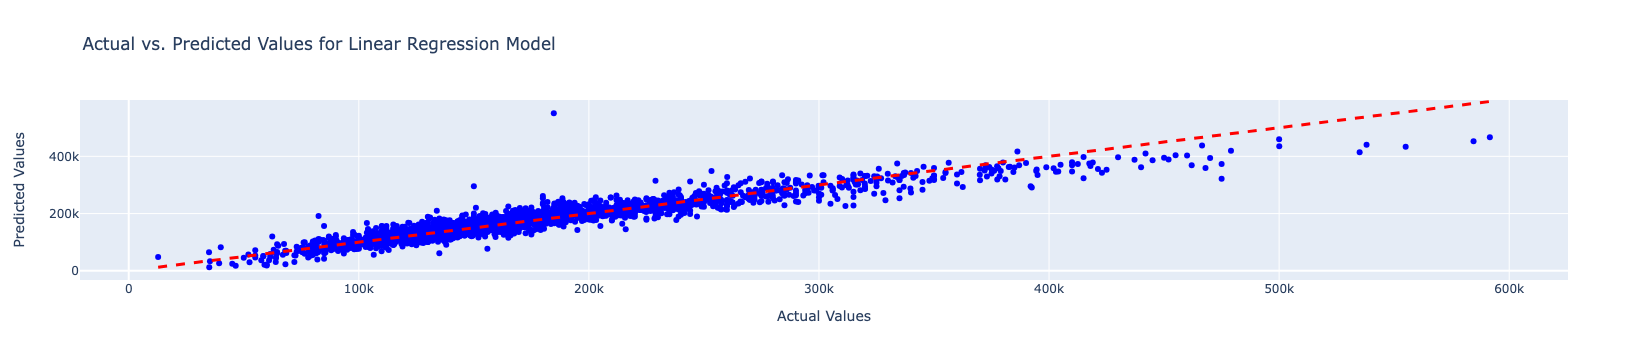

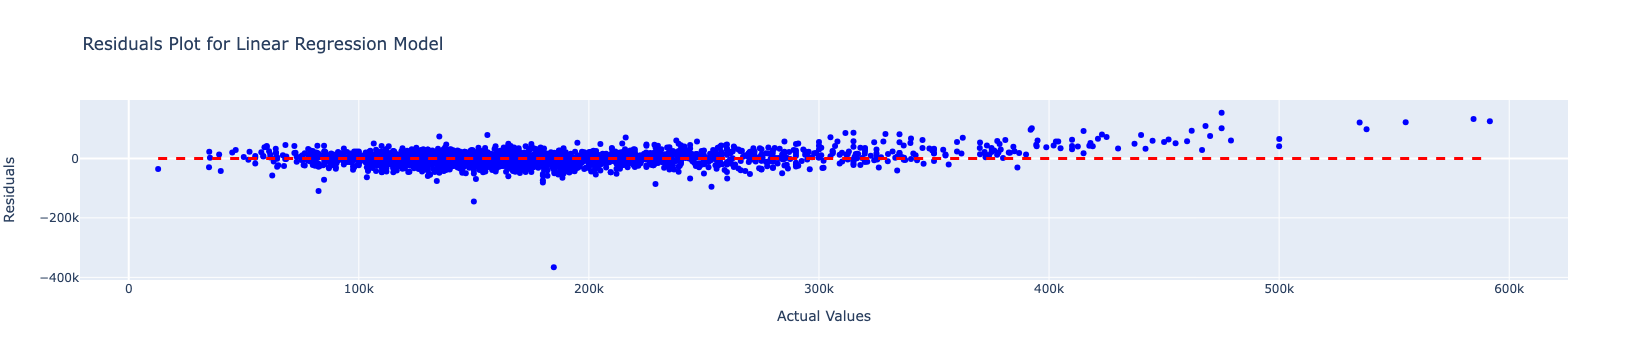

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     540.6
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        08:58:39   Log-Likelihood:                -29509.
No. Observations:                2571   AIC:                         5.910e+04
Df Residuals:                    2530   BIC:                         5.934e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.14

In [650]:
#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = ft_train['SalePrice']
y_array = y.values


# Perform linear regression using scikit-learn
model = LinearRegression()
model.fit(X, y)

X_with_intercept = sm.add_constant(X)  # Add intercept term
model_sm = sm.OLS(y,X_with_intercept).fit()

# Make predictions using the trained model
predictions = model.predict(X)


# Rsquared value
print("R Squared on the test set:", r2_score(y, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)



# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values
fig.add_trace(go.Scatter(x=y, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()


# Plotting residuals
residuals = y - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals
fig2.add_trace(go.Scatter(x=y, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y), x1=max(y), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")


fig2.update_layout(title="Residuals Plot for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()


# Using statsmodels to check p-values
print(model_sm.summary())
print('\n')

# Mean Squared Error (MSE)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y, predictions, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

print('\n')

print("F-statistic:", model_sm.fvalue)
print("F-statistic p-value:", model_sm.f_pvalue)

In [557]:
# qqplot(residuals, line='s')
# plt.title("QQ Plot")
# plt.show()

# Test Train Split Model

I was originally using the full dataset to train my model and test it on the same data. We will now look at how the results are from splitting the data.

R Squared on the test set: 0.9027650563672662
Mean Squared Error (MSE) on the test set: 474075536.83544654
Root Mean Squared Error (RMSE) on the test set: 21773.2757488497


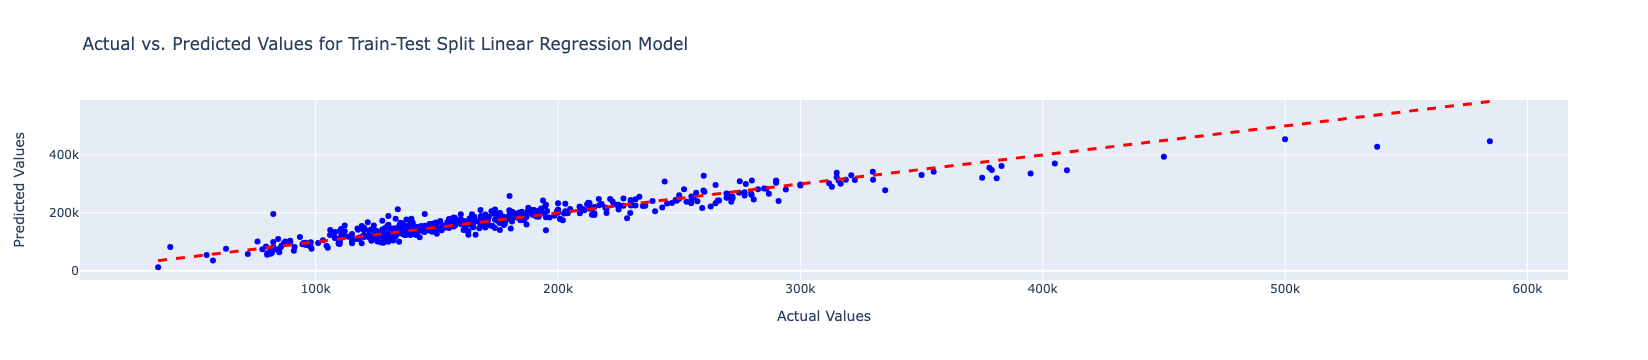

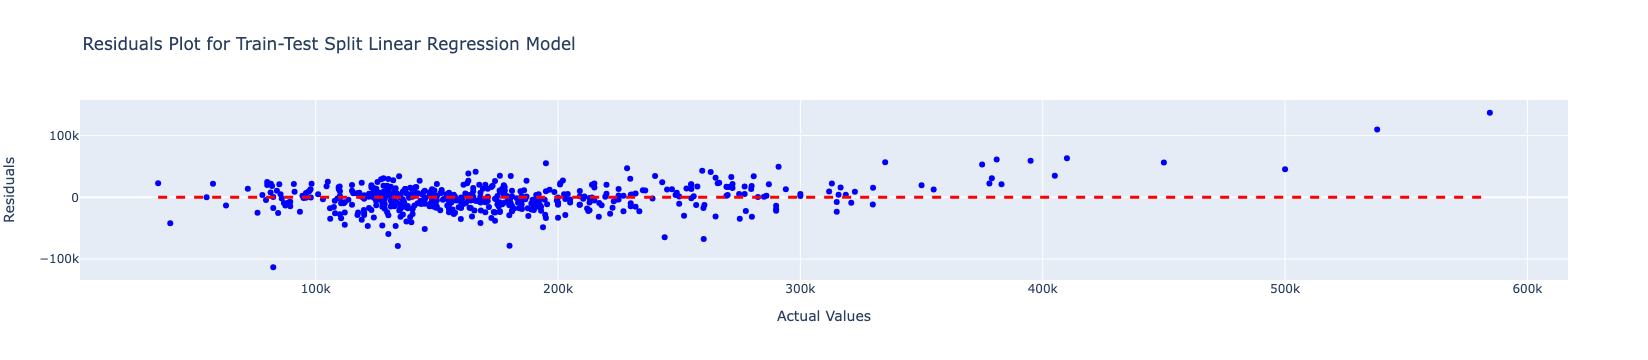

In [651]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rsquared value
print("R Squared on the test set:", r2_score(y_test, predictions))


# Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE) on the test set:", mse)

# Root Mean Squared Error (RMSE) on the test set
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)


# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values on the test set
fig.add_trace(go.Scatter(x=y_test, y=predictions, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=min(y_test), y1=max(y_test),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

# Plotting residuals
residuals = y_test - predictions
fig2 = go.Figure()

# Add a scatter plot for actual values and residuals on the test set
fig2.add_trace(go.Scatter(x=y_test, y=residuals, mode='markers', marker=dict(color='blue'), 
                         name='Residuals'))

# Add a horizontal line at y=0 for reference
fig2.add_shape(type="line", x0=min(y_test), x1=max(y_test), y0=0, y1=0,
              line=dict(color="red", width=3, dash='dash'),
              name="Zero Residuals Line")

fig2.update_layout(title="Residuals Plot for Train-Test Split Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Residuals")

fig2.show()

print('\n')


# K-Fold Multiple Linear Regression

In [652]:

#the features will be X (independent variables)
X = ft_train.drop('SalePrice', axis=1)
#the target (dependent variable) will be y
y = ft_train['SalePrice']

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for K-Fold Cross-Validation
num_folds = 5 # You can adjust this number based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}")


Cross-Validation Scores: [0.90276506 0.83404776 0.89786287 0.90674172 0.89476719] 

Mean R^2: 0.8872369197157877 

Standard Deviation R^2: 0.026908225318425745


In [657]:
#use random forest function from sklearn ensemble
forest = RandomForestRegressor()

# train model
model = forest.fit(X_train, y_train)
#Performance Evaluation
forest.score(X_test, y_test)


#label encoder ordinal
#feature importance


0.8959317700705697

<Axes: >

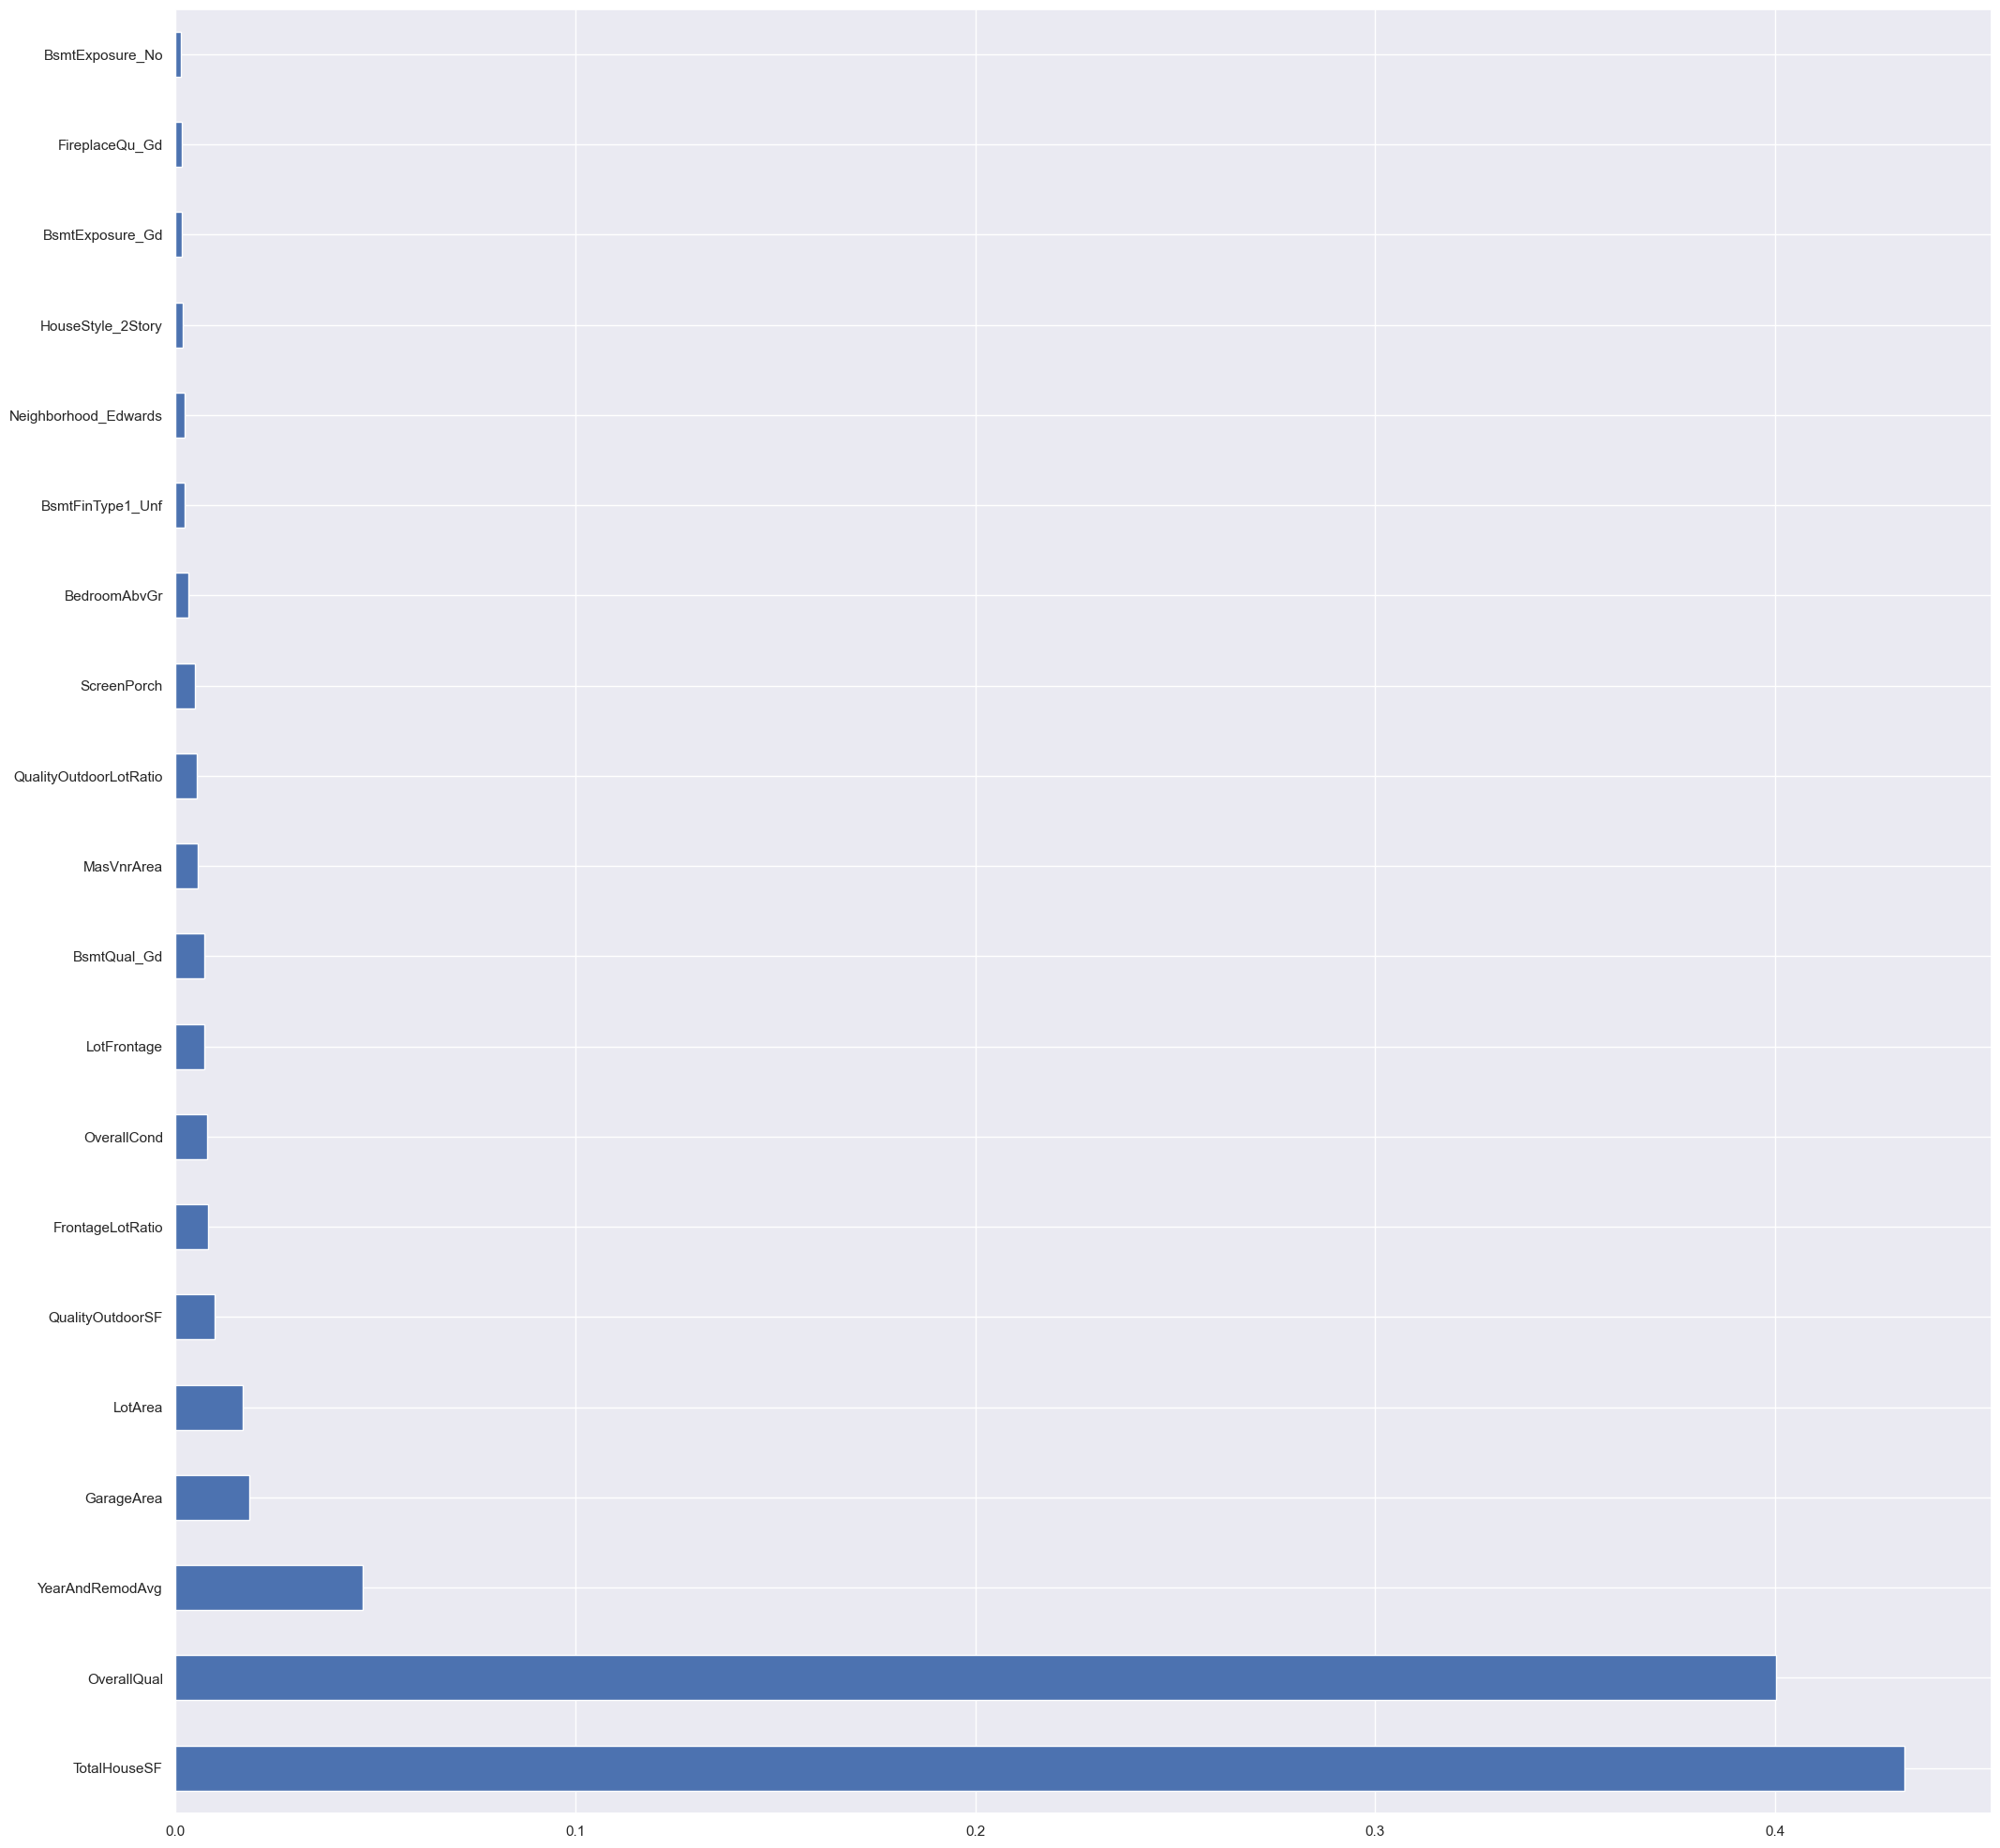

In [661]:

feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')